In [1]:
%matplotlib inline  

import glob
import time
import pickle
import clearbit

import tweepy
import networkx as nx
import matplotlib

import matplotlib.pyplot as plt

In [2]:
auth = tweepy.OAuthHandler('', '')
auth.set_access_token('', '')

twitter = tweepy.API(auth)

In [3]:
def get_friends_ids(twitter_id):
    return twitter.friends_ids(twitter_id, count=5000, stringify_ids=True)


def get_friends(twitter_id):
    """Making API calls to twitter can be expensive due to the low
    rate limit. Connections with friends will not change often so
    cache the connection information on disk
    """
    
    try:
        twitter_ids = pickle.load(open('friends/%s' % twitter_id, 'rb'))
    except FileNotFoundError:
        try:
            twitter_ids = get_friends_ids(twitter_id)
        except tweepy.error.RateLimitError:
            print('Waiting 15 minutes, then we will try again')
            time.sleep(15 * 60)
            twitter_ids = get_friends_ids(twitter_id)

        pickle.dump(twitter_ids, open('friends/%s' % twitter_id, 'wb'))

    return twitter_ids

In [4]:
def get_friends_connections_edges(primary_id, limit=70):
        
    twitter_ids = [f.split('/')[1] for f in glob.glob('friends/*')][:limit]
    
    # All the nodes will connect to the primary_id, so removing the id will disable them
    if primary_id in twitter_ids:
        twitter_ids.remove(primary_id)

    for twitter_id in twitter_ids:
        friend_ids = get_friends(twitter_id)

        # I only want to show the friends who are also following me back
        # So this can be seen as a mutual friendship
        # It will remove alot of noise like celebrities and companies.
        if primary_id in friend_ids:
            friend_ids = list(filter(lambda x: x in twitter_ids, friend_ids))
            
            for edge in zip([twitter_id] * len(friend_ids), friend_ids):
                yield edge

In [5]:
def get_connections_edges(primary_id, limit=70):
    twitter_ids = [f.split('/')[1] for f in glob.glob('friends/*')][:limit]
    edges = zip([primary_id] * len(twitter_ids), twitter_ids)
    return edges

In [6]:
def draw_edges(edges, primary_id):
    graph = nx.Graph()
    graph.add_edges_from(edges)
    position = nx.spring_layout(graph)
    if primary_id in graph.nodes():
        nx.draw(graph, position, nodelist=set([primary_id]), node_color="darkblue", edge_color='black', node_size=1800)
    nx.draw(graph, position, nodelist=set(graph.nodes()) - set([primary_id]), node_color="blue", edge_color='#55ACEE', width=4)
    plt.show()

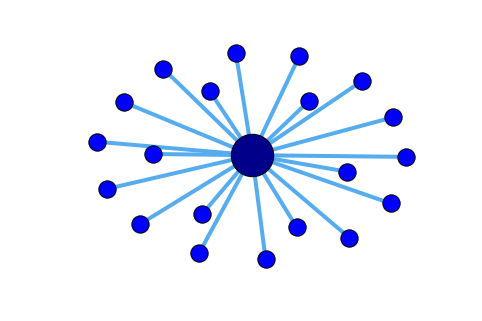

In [7]:
primary_id = '14981816' # http://www.twitter.com/markdessain
limit = 20

draw_edges(
    get_connections_edges(primary_id, limit), 
    primary_id
)

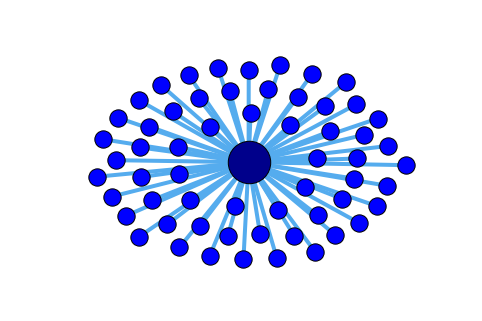

In [8]:
primary_id = '14981816' # http://www.twitter.com/markdessain
limit = 60

draw_edges(
    get_connections_edges(primary_id, limit), 
    primary_id
)

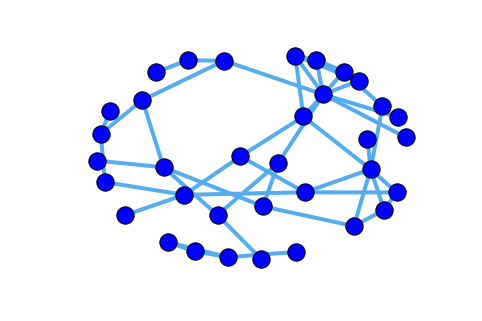

In [9]:
primary_id = '14981816' # http://www.twitter.com/markdessain
limit = 60

draw_edges(
    get_friends_connections_edges(primary_id, limit), 
    primary_id
)